# Vein Feature Extraction #

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

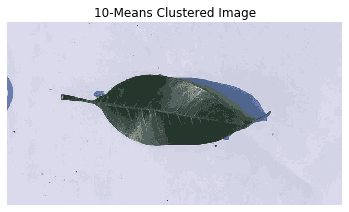

In [125]:
# Read an Image from dataset
original_img = cv2.imread('MangoLeavesDatabase/chausa/front/chausa_front_7abqlymugm1s29lx4al14dl7.jpg')
# Convert color channels from BGR to RGB
img2rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
# Apply K-Means to reduce color space in image
img_pixels = np.float32(img2rgb.reshape((-1, 3)))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10 # no of clusters
ret,labels,centers = cv2.kmeans(img_pixels, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
cluster_img_flat = centers[labels.flatten()]
cluster_img = cluster_img_flat.reshape(img2rgb.shape)
# Display Clustered Imge
plt.axis('off')
plt.title( str(K) + '-Means Clustered Image')
plt.imshow(cluster_img)

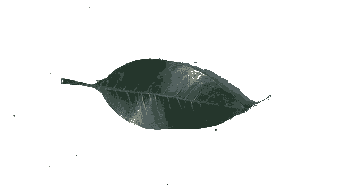

In [126]:
# Change all shadow bluish pixels to white in clustered image
for i,p in enumerate(cluster_img_flat):
    max_intensity = max(p)
    if max_intensity == p[2]:
        cluster_img_flat[i] = [255, 255, 255]
img_shadow_free = cluster_img_flat.reshape(img2rgb.shape)
plt.axis('off')
plt.imshow(img_shadow_free)

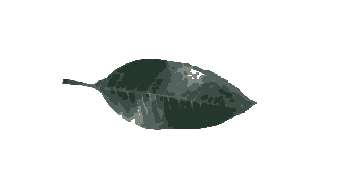

In [127]:
# Apply Morphological closing
kernel = np.ones((5,5), np.uint8)
opening = cv2.morphologyEx(img_shadow_free, cv2.MORPH_CLOSE, kernel)
plt.axis('off')
plt.imshow(opening)

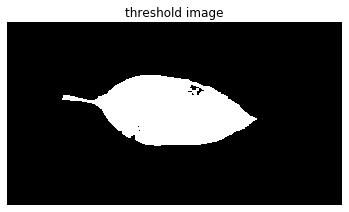

In [128]:
# Obtain threshold image
gray = cv2.cvtColor(opening, cv2.COLOR_RGB2GRAY)
retval, thresh_img = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.axis('off')
plt.title("threshold image")
plt.imshow(thresh_img, cmap="gray")

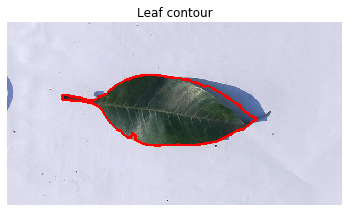

In [129]:
# draw contour
contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
leaf_contour = max(contours, key=cv2.contourArea)
contour_img = cv2.drawContours(img2rgb, [leaf_contour], 0, (255, 0, 0), 3)
plt.axis("off")
plt.title("Leaf contour")
plt.imshow(contour_img)

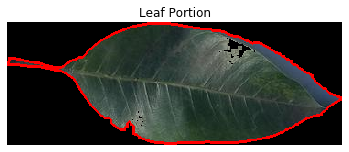

In [189]:
# Crop leaf bounding rectangle
x, y, w, h = cv2.boundingRect(leaf_contour)
# Remove shadow from original image by bitwise and it with threshold image
img = np.bitwise_and(img2rgb, cv2.cvtColor(thresh_img,cv2.COLOR_GRAY2RGB))
leaf_portion = img[y:y+h, x:x+w]
plt.axis('off')
plt.title("Leaf Portion")
plt.imshow(leaf_portion, cmap='gray')

(134, 366)


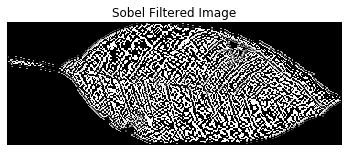

In [193]:
# Apply sobel filter to image for vein detection
leaf_portion = cv2.cvtColor(leaf_portion, cv2.COLOR_RGB2GRAY)
sobel_img = cv2.Sobel(leaf_portion,cv2.CV_64F,1,1,ksize=3)
sobel_img = np.uint8(sobel_img)
print(sobel_img.shape)
plt.axis('off')
plt.title('Sobel Filtered Image')
plt.imshow(sobel_img, cmap='gray')

In [188]:
# Vein Feature
# Calculate ratio of no of non-black pixels to total no of leaf pixels
non_black_pixels= 0
for intensity in sobel_img.flatten():
    if intensity > 0:
        non_black_pixels += 1

leaf_pixels = cv2.contourArea(leaf_contour)
print('Non-Black Pixels : ', non_black_pixels)
print('Total Leaf Pixels : ', leaf_pixels)
print('Ratio : ', non_black_pixels/leaf_pixels)

Non-Black Pixels :  26327
Total Leaf Pixels :  28166.0
Ratio :  0.9347085138109777


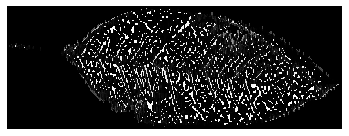

In [219]:
# Apply Morphological erosion on sobel image
kernel = np.ones((3,1), np.uint8)
erosion = cv2.morphologyEx(sobel_img, cv2.MORPH_ERODE, kernel)
plt.axis('off')
plt.imshow(erosion, cmap='gray')